In [7]:
# import library and load dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# load dataset
data = pd.read_csv('data.csv', delimiter=';')

# preprocess

# check if there is missing value
data.isnull().sum()

# encoding categorical variable
# Dropout -> 0, Enrolled -> 1, Graduate -> 1
data['Target'] = data['Target'].map({'Dropout': 0, 'Enrolled': 1, 'Graduate': 1})

# form features and target
X = data.drop(['Target'], axis=1)
y = data['Target']

# change column name Nacionality to Nationality
X.rename(columns={'Nacionality': 'Nationality'}, inplace=True)

# change Nationality value 1 to 1, all other to 0
X['Nationality'] = X['Nationality'].apply(lambda x: 1 if x == 1 else 0)

# drop Gender column to avoid discrimination
X = X.drop(['Gender'], axis=1)

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split dataset
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [8]:
# hyper parameter search for k-NN classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': range(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
best_k = grid_search.best_params_['n_neighbors']

{'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'uniform'}
0.8505242170706173


In [9]:
# cross validation to evaluate model consistently
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=best_k, weights='uniform', metric='manhattan')
scores = cross_val_score(knn, X_train_scaled, y_train, cv=10, scoring='accuracy')

print("accuracy mean:", scores.mean(), "accuracy std:", scores.std())

accuracy mean: 0.8496759014740481 accuracy std: 0.0085339721201205


In [10]:
# compare results with unscaled data

knn = KNeighborsClassifier(n_neighbors=best_k, weights='uniform', metric='manhattan')
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')

print("accuracy mean:", scores.mean(), "accuracy std:", scores.std())

accuracy mean: 0.805027928490261 accuracy std: 0.009981027585761285


In [11]:
# using K-NN to predict the target

knn = KNeighborsClassifier(n_neighbors=best_k, weights='uniform', metric='manhattan')
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

# accuracy, precision, recall, f1-score

from sklearn.metrics import classification_report

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = classification_report(y_test, y_pred, output_dict=True)['1'].values()

print("accuracy", accuracy)
print("precision", precision)
print("recall", recall)
print("f1_score", f1_score)

# confusion matrix

from sklearn.metrics import confusion_matrix

print("")
print("confusion matrix: [TP, FP], [FN, TN]")
confusion_matrix(y_test, y_pred)

accuracy 0.8293785310734463
precision 0.8091715976331361
recall 0.961335676625659
f1_score 0.878714859437751

confusion matrix: [TP, FP], [FN, TN]


array([[187, 129],
       [ 22, 547]])

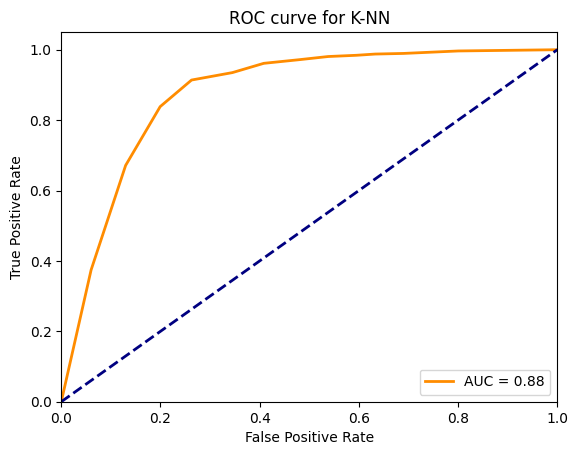

In [12]:
# draw roc curve and calculate auc

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_proba = knn.predict_proba(X_test_scaled)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for K-NN')
plt.legend(loc='lower right')
plt.show()
